In [3]:
import pandas as pd

df = pd.read_csv('en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


In [4]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_text(row))
df.head()

,en,fr
0,youre very clever,vous etes fort ingenieuse
1,are there kids,y atil des enfants
2,come in,entrez
3,wheres boston,ou est boston
4,you see what i mean,vous voyez ce que je veux dire


In [5]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')

Max phrase length (English): 7
Max phrase length (French): 14


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=en_max_len, padding='post')

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=fr_max_len, padding='post')

In [7]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12195


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout

np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Embedding(en_vocab_size, 256, input_length=en_max_len, mask_zero=True))
model.add(LSTM(256))
model.add(RepeatVector(fr_max_len))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

c:\Users\LXRDKEUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                      │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm (LSTM)                                │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ repeat_vector (RepeatVector)               │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_1 (LSTM)                              │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout (Dropout)                          │ ?                               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ time_distributed (TimeDistributed)         │ ?                               │       0 (unbuilt) │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(en_x, fr_y, epochs=10, batch_size=500, validation_split=0.2, callbacks=[callback])

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7143 - loss: 2.2221 - val_accuracy: 0.7155 - val_loss: 2.0961
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7199 - loss: 2.0908 - val_accuracy: 0.7277 - val_loss: 2.0513
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7257 - loss: 2.0443 - val_accuracy: 0.7280 - val_loss: 2.0036
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7262 - loss: 1.9931 - val_accuracy: 0.7290 - val_loss: 1.9641
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7279 - loss: 1.9516 - val_accuracy: 0.7313 - val_loss: 1.9396
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7299 - loss: 1.9210 - val_accuracy: 0.7323 - val_loss: 1.9211
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.7313 - loss: 1.9016 - val_accuracy: 0.7345 - val_loss: 1.9045
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7328 - loss: 1.8858 - val_accuracy: 0.7367 - v

[]

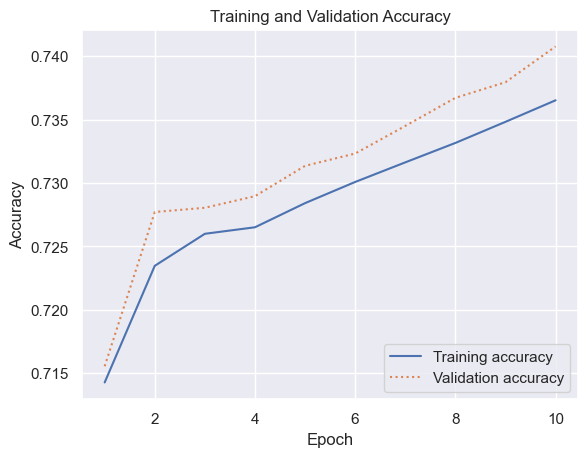

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [13]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, en_max_len):
    sequence = en_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=en_max_len, padding='post')
    prediction = model.predict(padded_sequence, verbose=0)[0]
    indexes = [np.argmax(idx) for idx in prediction]
    return fr_tokenizer.sequences_to_texts([indexes])[0]

texts = en[40000:40010].values

for text in texts:
    translated = translate_text(text, model, en_tokenizer, fr_tokenizer, en_max_len)
    print(f'{text} => {translated}')

its fall now => je est
im losing => je est
it was quite funny => je est
thats not unusual => je ne pas
i think ill do that => je ne pas pas
tom looks different => je est
its worth a try => je est
fortune smiled on him => je est
lets hit the road => tom
i love winning => tom est


In [14]:
translate_text('Hello world', model, en_tokenizer, fr_tokenizer, en_max_len)

'je'